In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time
import numpy as np

In [2]:
# baseline model with dropout and data augmentation on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [3]:
# load train and test dataset
def load_dataset():
    # load dataset
    data_x = np.load('data_x_original.npy')
    data_y = np.load('data_y_original.npy')
    #percentage of the dataset which will be on TRAIN - TEST - VALIDATION
    TOTAL_IMAGES = len(data_y)
    print("TOTAL_IMAGES = ", TOTAL_IMAGES)
    
    TRAIN_PERCENTAGE = 0.8
    TEST_PERCENTAGE = 0.1
    VALIDATION_PERCENTAGE = 0.1

    train_size = int(TRAIN_PERCENTAGE * TOTAL_IMAGES)
    test_size = int(TEST_PERCENTAGE * TOTAL_IMAGES)
    validation_size = int(VALIDATION_PERCENTAGE * TOTAL_IMAGES)

    train_x = data_x[:train_size] #taking train images from original data
    train_y = data_y[:train_size]
    data_x = data_x[train_size:] #removing train images from original data
    data_y = data_y[train_size:]

    test_x = data_x[:test_size] #taking test images from original data
    test_y = data_y[:test_size]
    data_x = data_x[test_size:] #removing test images from original data
    data_y = data_y[test_size:]

    validation_x = data_x #all the remainder images we can put on validation
    validation_y = data_y

    del data_x #free some unused memory
    del data_y

    print("train_size = ", len(train_y))
    print("test_size = ", len(test_y))
    print("validation_size = ", len(validation_y))
 # one hot encode target values
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)
    validation_y = to_categorical(validation_y)
    return train_x, train_y, test_x, test_y, validation_x, validation_y

In [4]:
# scale pixels
def prep_pixels(train, test, validation):
 # convert from integers to floats
 train_norm = train.astype('float32')
 test_norm = test.astype('float32')
 validation_norm = validation.astype('float32')
 # normalize to range 0-1
 train_norm = train_norm / 255.0
 test_norm = test_norm / 255.0
 validation_norm = validation_norm / 255.0
 # return normalized images
 return train_norm, test_norm, validation_norm

In [5]:
# define cnn model
def define_model():
    new_model = Sequential()
    
    model = tf.keras.applications.VGG19(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=(128,128,3),
        pooling=None,
        classes=4,
       # classifier_activation="softmax",
    #    **kwargs
        )
    
    new_model.add(model)
    #3rd conv layer
    new_model.add(tf.keras.layers.Conv2D(32, 3, padding="same"))
    new_model.add(tf.keras.layers.BatchNormalization())
    new_model.add(tf.keras.layers.Activation("relu"))
    new_model.add(tf.keras.layers.MaxPooling2D(2, padding='same'))
    new_model.add(tf.keras.layers.Dropout(0.4))
    #4th conv layer
    new_model.add(tf.keras.layers.Conv2D(64, 3, padding="same"))
    new_model.add(tf.keras.layers.BatchNormalization())
    new_model.add(tf.keras.layers.Activation("relu"))
    new_model.add(tf.keras.layers.MaxPooling2D(2, padding='same'))
    new_model.add(tf.keras.layers.Dropout(0.3))
    #Flatten Layer
    new_model.add(tf.keras.layers.Flatten())

    new_model.add(tf.keras.layers.Dense(128))
    new_model.add(tf.keras.layers.BatchNormalization())
    new_model.add(tf.keras.layers.Activation("relu"))
    new_model.add(tf.keras.layers.Dropout(0.2))
    #output Dense Layer
    new_model.add(tf.keras.layers.Dense(4))
    new_model.add(tf.keras.layers.Activation('softmax'))
    opt = SGD(lr=0.0001, momentum=0.9)
    new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return new_model

In [6]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
 # plot loss
    model_trained = history
    accuracy = model_trained.history['accuracy']
    val_accuracy = model_trained.history['val_accuracy']
    loss = model_trained.history['loss']
    val_loss = model_trained.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Acurácia de treino')
    plt.plot(epochs, val_accuracy, 'g', label='Acurácia de validação')
    plt.title('Acurácia de treino e validação')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Perda no treino')
    plt.plot(epochs, val_loss, 'g', label='Perda na validação')
    plt.title('Perda na validação e treino')
    plt.legend()
    plt.show()

In [7]:
epochs = 400
verb = 2

In [8]:
trainX, trainY, testX, testY, validationX, validationY = load_dataset()
print(trainY)
 # prepare pixel data
trainX, testX, validationX = prep_pixels(trainX, testX, validationX)
 # define model
model = define_model()
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
 # prepare iterator
it_train = datagen.flow(trainX, trainY, batch_size=64)
 # fit model
steps = int(trainX.shape[0] / 64)
history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(validationX, validationY), verbose=verb)


TOTAL_IMAGES =  592
train_size =  473
test_size =  59
validation_size =  60
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


C:\Users\tmcle\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/400
7/7 - 31s - loss: 1.7374 - accuracy: 0.2347 - val_loss: 1.4372 - val_accuracy: 0.2333 - 31s/epoch - 4s/step
Epoch 2/400
7/7 - 5s - loss: 1.6296 - accuracy: 0.3130 - val_loss: 1.4199 - val_accuracy: 0.2333 - 5s/epoch - 677ms/step
Epoch 3/400
7/7 - 5s - loss: 1.6013 - accuracy: 0.3154 - val_loss: 1.4015 - val_accuracy: 0.2500 - 5s/epoch - 675ms/step
Epoch 4/400
7/7 - 5s - loss: 1.5550 - accuracy: 0.3227 - val_loss: 1.3822 - val_accuracy: 0.2500 - 5s/epoch - 675ms/step
Epoch 5/400
7/7 - 5s - loss: 1.5566 - accuracy: 0.3056 - val_loss: 1.3717 - val_accuracy: 0.3167 - 5s/epoch - 663ms/step
Epoch 6/400
7/7 - 5s - loss: 1.4930 - accuracy: 0.3415 - val_loss: 1.3632 - val_accuracy: 0.3167 - 5s/epoch - 725ms/step
Epoch 7/400
7/7 - 5s - loss: 1.5247 - accuracy: 0.3130 - val_loss: 1.3502 - val_accuracy: 0.3000 - 5s/epoch - 679ms/step
Epoch 8/400
7/7 - 5s - loss: 1.4824 - accuracy: 0.3374 - val_loss: 1.3412 - val_accuracy: 0.3167 - 5s/epoch - 667ms/step
Epoch 9/400
7/7 - 5s - loss: 1.44

Epoch 69/400
7/7 - 5s - loss: 0.7354 - accuracy: 0.7164 - val_loss: 0.8679 - val_accuracy: 0.6833 - 5s/epoch - 690ms/step
Epoch 70/400
7/7 - 5s - loss: 0.7646 - accuracy: 0.7188 - val_loss: 0.7440 - val_accuracy: 0.7667 - 5s/epoch - 745ms/step
Epoch 71/400
7/7 - 5s - loss: 0.7623 - accuracy: 0.6919 - val_loss: 0.7479 - val_accuracy: 0.7500 - 5s/epoch - 690ms/step
Epoch 72/400
7/7 - 5s - loss: 0.7873 - accuracy: 0.6993 - val_loss: 0.6961 - val_accuracy: 0.8333 - 5s/epoch - 692ms/step
Epoch 73/400
7/7 - 5s - loss: 0.7668 - accuracy: 0.7017 - val_loss: 0.6812 - val_accuracy: 0.7500 - 5s/epoch - 682ms/step
Epoch 74/400
7/7 - 5s - loss: 0.7100 - accuracy: 0.7286 - val_loss: 0.6802 - val_accuracy: 0.8000 - 5s/epoch - 692ms/step
Epoch 75/400
7/7 - 5s - loss: 0.7549 - accuracy: 0.7090 - val_loss: 0.7121 - val_accuracy: 0.7000 - 5s/epoch - 693ms/step
Epoch 76/400
7/7 - 5s - loss: 0.7090 - accuracy: 0.7299 - val_loss: 0.6724 - val_accuracy: 0.8167 - 5s/epoch - 744ms/step
Epoch 77/400
7/7 - 5s - 

Epoch 136/400
7/7 - 5s - loss: 0.4427 - accuracy: 0.8875 - val_loss: 0.5353 - val_accuracy: 0.8500 - 5s/epoch - 691ms/step
Epoch 137/400
7/7 - 5s - loss: 0.4489 - accuracy: 0.8582 - val_loss: 0.5146 - val_accuracy: 0.8167 - 5s/epoch - 697ms/step
Epoch 138/400
7/7 - 5s - loss: 0.4421 - accuracy: 0.8680 - val_loss: 0.5904 - val_accuracy: 0.8167 - 5s/epoch - 696ms/step
Epoch 139/400
7/7 - 5s - loss: 0.4765 - accuracy: 0.8594 - val_loss: 0.4856 - val_accuracy: 0.8333 - 5s/epoch - 748ms/step
Epoch 140/400
7/7 - 5s - loss: 0.4230 - accuracy: 0.8900 - val_loss: 0.5699 - val_accuracy: 0.8167 - 5s/epoch - 694ms/step
Epoch 141/400
7/7 - 5s - loss: 0.4070 - accuracy: 0.9022 - val_loss: 0.5099 - val_accuracy: 0.8167 - 5s/epoch - 689ms/step
Epoch 142/400
7/7 - 5s - loss: 0.4220 - accuracy: 0.8900 - val_loss: 0.5691 - val_accuracy: 0.8000 - 5s/epoch - 682ms/step
Epoch 143/400
7/7 - 5s - loss: 0.3943 - accuracy: 0.8949 - val_loss: 0.4992 - val_accuracy: 0.8333 - 5s/epoch - 697ms/step
Epoch 144/400
7/

Epoch 203/400
7/7 - 5s - loss: 0.2642 - accuracy: 0.9511 - val_loss: 0.5202 - val_accuracy: 0.8167 - 5s/epoch - 699ms/step
Epoch 204/400
7/7 - 5s - loss: 0.2940 - accuracy: 0.9193 - val_loss: 0.6917 - val_accuracy: 0.7333 - 5s/epoch - 684ms/step
Epoch 205/400
7/7 - 5s - loss: 0.2396 - accuracy: 0.9643 - val_loss: 0.4103 - val_accuracy: 0.8667 - 5s/epoch - 745ms/step
Epoch 206/400
7/7 - 5s - loss: 0.2449 - accuracy: 0.9554 - val_loss: 0.4207 - val_accuracy: 0.9000 - 5s/epoch - 750ms/step
Epoch 207/400
7/7 - 5s - loss: 0.2534 - accuracy: 0.9584 - val_loss: 0.4448 - val_accuracy: 0.8667 - 5s/epoch - 697ms/step
Epoch 208/400
7/7 - 5s - loss: 0.2386 - accuracy: 0.9584 - val_loss: 0.4149 - val_accuracy: 0.8667 - 5s/epoch - 697ms/step
Epoch 209/400
7/7 - 5s - loss: 0.2337 - accuracy: 0.9707 - val_loss: 0.3905 - val_accuracy: 0.9000 - 5s/epoch - 697ms/step
Epoch 210/400
7/7 - 5s - loss: 0.2628 - accuracy: 0.9267 - val_loss: 0.4312 - val_accuracy: 0.8833 - 5s/epoch - 682ms/step
Epoch 211/400
7/

Epoch 270/400
7/7 - 5s - loss: 0.1525 - accuracy: 0.9780 - val_loss: 0.3643 - val_accuracy: 0.9000 - 5s/epoch - 697ms/step
Epoch 271/400
7/7 - 5s - loss: 0.1473 - accuracy: 0.9878 - val_loss: 0.3604 - val_accuracy: 0.9000 - 5s/epoch - 685ms/step
Epoch 272/400
7/7 - 5s - loss: 0.1314 - accuracy: 0.9951 - val_loss: 0.4405 - val_accuracy: 0.8500 - 5s/epoch - 700ms/step
Epoch 273/400
7/7 - 5s - loss: 0.1390 - accuracy: 0.9888 - val_loss: 0.2972 - val_accuracy: 0.9167 - 5s/epoch - 748ms/step
Epoch 274/400
7/7 - 5s - loss: 0.1329 - accuracy: 0.9927 - val_loss: 0.4493 - val_accuracy: 0.8500 - 5s/epoch - 700ms/step
Epoch 275/400
7/7 - 5s - loss: 0.1478 - accuracy: 0.9853 - val_loss: 0.3593 - val_accuracy: 0.8833 - 5s/epoch - 696ms/step
Epoch 276/400
7/7 - 5s - loss: 0.1649 - accuracy: 0.9731 - val_loss: 0.4565 - val_accuracy: 0.8500 - 5s/epoch - 702ms/step
Epoch 277/400
7/7 - 5s - loss: 0.1429 - accuracy: 0.9927 - val_loss: 0.3905 - val_accuracy: 0.8333 - 5s/epoch - 680ms/step
Epoch 278/400
7/

Epoch 337/400
7/7 - 5s - loss: 0.1024 - accuracy: 0.9853 - val_loss: 0.4700 - val_accuracy: 0.8333 - 5s/epoch - 700ms/step
Epoch 338/400
7/7 - 5s - loss: 0.1053 - accuracy: 0.9780 - val_loss: 0.3255 - val_accuracy: 0.8667 - 5s/epoch - 697ms/step
Epoch 339/400
7/7 - 5s - loss: 0.1168 - accuracy: 0.9804 - val_loss: 0.6465 - val_accuracy: 0.7667 - 5s/epoch - 698ms/step
Epoch 340/400
7/7 - 5s - loss: 0.1183 - accuracy: 0.9853 - val_loss: 0.5213 - val_accuracy: 0.7667 - 5s/epoch - 699ms/step
Epoch 341/400
7/7 - 5s - loss: 0.1015 - accuracy: 0.9951 - val_loss: 0.6065 - val_accuracy: 0.7833 - 5s/epoch - 695ms/step
Epoch 342/400
7/7 - 5s - loss: 0.1118 - accuracy: 0.9976 - val_loss: 0.3724 - val_accuracy: 0.8333 - 5s/epoch - 699ms/step
Epoch 343/400
7/7 - 5s - loss: 0.1069 - accuracy: 0.9853 - val_loss: 0.5240 - val_accuracy: 0.8167 - 5s/epoch - 698ms/step
Epoch 344/400
7/7 - 5s - loss: 0.1033 - accuracy: 0.9927 - val_loss: 0.4015 - val_accuracy: 0.9000 - 5s/epoch - 693ms/step
Epoch 345/400
7/

In [9]:
 # evaluate model
_, acc = model.evaluate(testX, testY, verbose=verb)
print('Acurácia: %.3f' % (acc * 100.0))

2/2 - 4s - loss: 0.8555 - accuracy: 0.7119 - 4s/epoch - 2s/step
Acurácia: 71.186


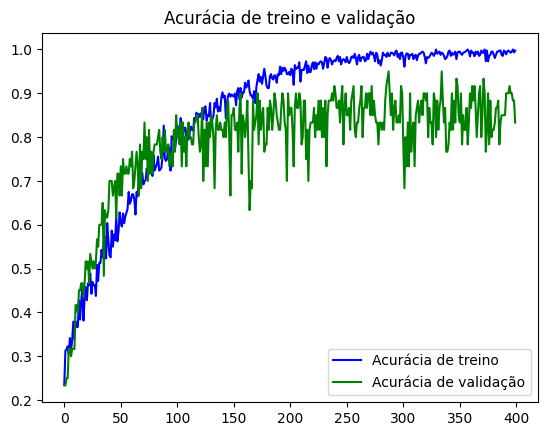

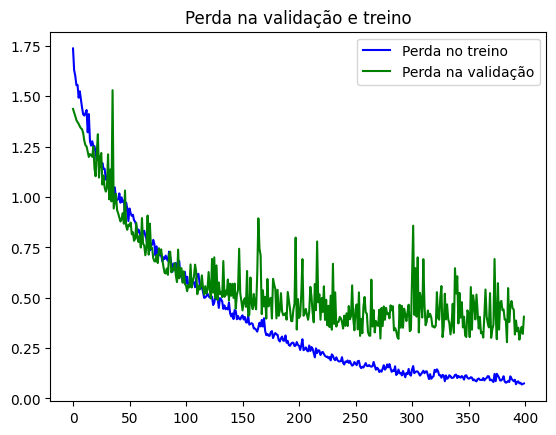

In [10]:
 # learning curves
summarize_diagnostics(history)

In [11]:
model_name = f'displasys-VGG19-baseline-holdout-{epochs}epochs_transferlearning.npy'
model.save(model_name)

INFO:tensorflow:Assets written to: displasys-VGG19-baseline-holdout-400epochs_transferlearning.npy\assets


INFO:tensorflow:Assets written to: displasys-VGG19-baseline-holdout-400epochs_transferlearning.npy\assets


In [12]:
# entry point, run the test harness
#run_test_harness(epochs=100, verb=1)